In [1]:
!pip install openpyxl
!pip install wordcloud
# GDAL Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal -y --quiet
# Install rtree - Geopandas requirment
!apt install python3-rtree -y --quiet
# Install Geopandas
#!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes --quiet
# Install Pysal
!pip install pysal --quiet
# Install splot --> pysal
!pip install splot --quiet
# Install mapclassify
!pip install mapclassify --quiet
!pip install folium

# Modules for data processing
import pandas as pd
import numpy as np
import os
import re
import sys
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings("ignore")

# REFERENCE: https://www.kaggle.com/dmitryuarov/eda-covid-19-impact-on-digital-learning
STATE_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'District Of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
STATE_NAME = dict([(y, x) for x, y in STATE_ABBR.items()])

# ########################################################################
# ### analyze_dataset
# ########################################################################
# #
# # Simple function to help quickly analyze information & usability of
# # a dataset. Provides information about shape, null values, unique
# # values & basic statistical features.
# #
# # Inputs:
# #   1.  df_path (string) -> Dataset path (if available)
# #   2.  df (pandas dataframe) -> Dataset (if available)
# #   3.  direct_df (boolean) -> Whether dataset path or dataset is
# #       being provided
# #   4.  processing_func (function) -> If dataset needs to be processed
# #       before analyzing
# #   5.  Other arguments for pd.read_csv(...) if dataset path is being
# #       provided
# #
# # Return:   Either dataframe itself (if path provided) or head of
# #           dataframe (if dataframe provided)
# #
# ########################################################################

# def analyze_dataset(df_path = None, df = None, direct_df = False, processing_func = lambda x: x, **read_csv_args):
    
#     if(direct_df == False):
#         df = pd.read_csv(df_path, **read_csv_args)
#     df = processing_func(df)
    
#     num_rows, num_cols = df.shape
#     dtypes = dict(df.dtypes.items())
#     print("*****************")
#     print("Basic Info:")
#     print("*****************\n")
#     print(f"Shape of Dataset: {num_rows} rows, {num_cols} cols")
#     print("Columns:")
#     for col_idx, col in enumerate(df.columns):
#         print(f"\t{col_idx+1}. {col}\n\t\t\t\t\t\t\t\t{dtypes[col]}")
    
#     print("\n\n\n*****************")
#     print("Null Values:")
#     print("*****************\n")
#     nulls = pd.isnull(df).sum()
#     print(f"Total Nulls: {nulls.sum()}")
#     nulls = nulls[nulls > 0]
#     nulls = list(sorted(nulls.items(), key = lambda x: x[1], reverse = True))
#     print("Columns with missing values:")
#     for col_idx, (col_name, col_missin_num) in enumerate(nulls):
#         print(f"\t{col_idx + 1}. {col_name}\n\t\t\t\t\t\t\t\t{col_missin_num} missing ({col_missin_num / num_rows * 100:.1f}%)")
    
#     print("\n\n\n*****************")
#     print("Column-specific:")
#     print("*****************\n")
#     print("Unique values in columns:")
#     idx = 1
#     for col in df.columns:
#         nunique = df[col].nunique()
#         if(nunique < 10):
#             unique_vals = ["'" + str(x) + "'" for x in df[col].unique()]
#             print(f"{idx}. {col} has {nunique} unique values")
#             idx += 1
#             print(f"\t[ {', '.join(unique_vals)} ]")
#     print("\n\nStatistical Features:")
#     print(df.describe())
    
#     print("\n\n")
#     if(direct_df == True):
#         return df.head()
#     else:
#         return df

########################################################################
### load_main_dataset
########################################################################
#
# Function to load the main processed & merged dataset for
# engagement. Has options to merge selected datasets. The processing
# has been done separately in another function `process_main_dataset`
#
# Inputs:
#   1.  whether_merge_district (boolean) -> Whether to merge districts
#       data
#   2.  whether_merge_products (boolean) -> Whether to merge products
#       data
#   3.  whether_merge_dates (boolean) -> Whether to merge dates data
#
# Return:   Engagement data merged with other relevant datasets
#
########################################################################

def load_main_dataset(whether_merge_districts = True, whether_merge_products = True, whether_merge_dates = True):
    def reduce_dtype_size(df):
        numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
        for numeric_col in numeric_cols:
            if('float' in str(df[numeric_col].dtype)):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
            elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
            else:
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
        return df
    
    def merge_districts_data(engagement_data):
        districts_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/districts_data.csv')
        districts_data = reduce_dtype_size(districts_data)
        merged_engagement_data = pd.merge(engagement_data, districts_data, how = 'left', on = 'district_id')
        return merged_engagement_data

    def merge_products_data(engagement_data):
        products_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/products_data.csv')
        products_data = reduce_dtype_size(products_data)
        merged_engagement_data = pd.merge(engagement_data, products_data, how = 'left', left_on = 'lp_id', right_on = 'LP ID')
        merged_engagement_data = merged_engagement_data.drop('LP ID', axis = 1)
        return merged_engagement_data

    def merge_dates_data(engagement_data):
        dates_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/dates_data.csv', parse_dates = ['date'])
        dates_data = reduce_dtype_size(dates_data)
        merged_engagement_data = pd.merge(engagement_data, dates_data, how = 'left', left_on = 'time', right_on = 'date')
        merged_engagement_data = merged_engagement_data.drop('date', axis = 1)
        return merged_engagement_data

    engagement_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/engagement_data.csv', parse_dates = ['time'])
    engagement_data = reduce_dtype_size(engagement_data)
    if(whether_merge_districts == True):
        engagement_data = merge_districts_data(engagement_data)
    if(whether_merge_products == True):
        engagement_data = merge_products_data(engagement_data)
    if(whether_merge_dates == True):
        engagement_data = merge_dates_data(engagement_data)
    
    return engagement_data


# ########################################################################
# ### process_main_dataset
# ########################################################################
# #
# # Function to process the main processed & save it for
# # loading later from another function `load_main_dataset`.
# #
# # Inputs:
# #   1.  whether_load_url_html_data (boolean) -> Whether to process
# #       and save URL's HTML data
# #
# # Return:   None
# #
# ########################################################################

# def process_main_dataset(whether_load_url_html_data = False):
#     def get_all_na_idx(df):
#         all_na_idx = df.isnull().all(axis=1)
#         return all_na_idx[all_na_idx == True].keys()

#     def add_dummys(df, dummy_cols, remove_orig_dummy_cols = False):
#         dummy_df = df[dummy_cols]
#         dummy_df = pd.get_dummies(dummy_df)
        
#         df = pd.concat([df, dummy_df], axis = 1)
#         if(remove_orig_dummy_cols == True):
#             df = df.drop(dummy_cols, axis = 1)
        
#         return df

#     def reduce_dtype_size(df):
#         numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
#         for numeric_col in numeric_cols:
#             if('float' in str(df[numeric_col].dtype)):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
#             elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
#             else:
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
#         return df
    
#     def load_districts_data():
        
#         def districts_data_preprocessing(districts_data):
            
#             def process_lower_upper_bounds(df_series):
#                 processed_lower_series = []
#                 processed_upper_series = []
                
#                 for row in df_series:                
#                     if(pd.isnull(row) == True):
#                         processed_lower_series.append(row)
#                         processed_upper_series.append(row)
#                     else:
#                         assert(len(row[1:-1].split(', ')) == 2)
#                         lower_val, upper_val = row[1:-1].split(', ')
#                         lower_val = float(lower_val)
#                         upper_val = float(upper_val)
#                         processed_lower_series.append(lower_val)
#                         processed_upper_series.append(upper_val)
                
#                 return processed_lower_series, processed_upper_series
            
#             for col in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
#                 lower_series, upper_series = process_lower_upper_bounds(districts_data[col])
#                 districts_data[col + '_lower_bound'] = pd.Series(lower_series, index = districts_data.index)
#                 districts_data[col + '_upper_bound'] = pd.Series(upper_series, index = districts_data.index)
#                 districts_data[col + '_bound_avg'] = pd.Series(np.add(lower_series, upper_series) / 2.0, index = districts_data.index)
            
#             districts_data = districts_data.drop(['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'], axis = 1)
#             return districts_data
        
#         districts_data = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
        
#         districts_data = districts_data_preprocessing(districts_data)
#         districts_data = districts_data.drop(get_all_na_idx(districts_data.drop('district_id', axis = 1))).reset_index(drop = True)
#         districts_data = add_dummys(districts_data, ['locale'], remove_orig_dummy_cols = False)
        
#         #all_states = districts_data['state'].unique()
#         #district_id_state_map = dict(districts_data[['district_id', 'state']].values)
#         #state_district_id_map = dict([(x, [y for y in district_id_state_map if district_id_state_map[y] == x]) for x in all_states])
#         #districts_data = districts_data.drop('state', axis = 1)
        
#         districts_data = reduce_dtype_size(districts_data)
#         return districts_data

#     districts_data = load_districts_data()
    
#     # URL Information Extraction
#     #   For July 2021
#     #   Using similarweb.com
#     #   Avg Duration - in seconds
#     #   Total Visits - in 1000s
#     def load_url_html_data():
#         url_html_dict = {}

#         all_html_content = ""
#         with open(f'./Data/url_info/combined_url_info_data.txt', 'r') as html_file:
#             all_html_content = html_file.read()

#         tot_num_files = len([x for x in all_html_content.split('---') if len(x.strip()) != 0])
#         print(f"Total No. of files: {tot_num_files}\n\n")

#         for html_content_idx, html_content in enumerate(all_html_content.split('---')):
            
#             html_content = html_content.strip()
#             if(len(html_content) == 0):
#                 print("ERROR: URL not found")
#                 sys.exit("")
            
#             url_name = html_content.split('<')[0].strip()
#             html_content = '<'.join(html_content.split('<')[1:])
#             print(f"{html_content_idx + 1}. File: {url_name}\n")
#             if(url_name in url_html_dict):
#                 print("ERROR: Name already exists")
#                 sys.exit("")
#             url_html_dict[url_name] = {}
            
#             # Global Rank
#             global_rank = re.findall('\"GlobalRank":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(global_rank) != 1):
#                 print("ERROR: Global Rank")
#                 print(global_rank)
#                 sys.exit("")
#             global_rank = int(global_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['global_rank'] = global_rank

#             # Country
#             if('<img class="websiteRanks-titleIconImg" src="/images/flags-svg/flag-icon-us.svg">' in html_content):
#                 country = 'USA'
#             else:
#                 print("Country: Not USA!")
#                 country = 'Not_USA'
#             url_html_dict[url_name]['country'] = country
            
#             # Country Rank
#             country_rank = re.findall('\"CountryRanks":\{"\d+":\[\d+,\d+,-?\d+,\d+\]\}', html_content)
#             if(len(country_rank) != 1):
#                 print("ERROR: Country Rank")
#                 print(country_rank)
#                 sys.exit("")
#             country_rank = int(country_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['country_rank'] = country_rank
            
#             # Category
#             category = re.findall('<a class="websiteRanks-nameText" data-analytics-category="Internal Link" data-analytics-label="Category Rank/.+" href="/top-websites/category/.+" itemprop="significantLink">.+</a>', html_content)
#             if(len(category) != 1):
#                 print("ERROR: Category")
#                 print(category)
#                 url_html_dict[url_name]['main_category'] = np.nan
#                 url_html_dict[url_name]['sub_category'] = np.nan
#             else:
#                 category = category[0].split('Category Rank/')[1].split('"')[0]
#                 main_category = category.split('/')[0]
#                 url_html_dict[url_name]['main_category'] = main_category
#                 if(len(category.split('/')) != 1):
#                     sub_category = category.split('/')[-1]
#                 else:
#                     sub_category = ""
#                 url_html_dict[url_name]['sub_category'] = sub_category

#             # Category Rank
#             category_rank = re.findall('\"CategoryRank\":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(category_rank) != 1):
#                 print("ERROR: Category Rank")
#                 print(category_rank)
#                 sys.exit("")
#             category_rank = int(category_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['category_rank'] = category_rank

#             # Total Visits
#             total_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">.*\d+[KMB]</span>', html_content)
#             if(len(total_visits) != 1):
#                 print("ERROR: Total Visits")
#                 print(total_visits)
#                 url_html_dict[url_name]['total_visits'] = np.nan
#             else:
#                 total_visits = total_visits[0].split('>')[1].split('<')[0]
#                 units = total_visits[-1]
#                 total_visits = float(''.join([x for x in total_visits if x.isdigit()]))
#                 if(units == 'K'):
#                     total_visits = total_visits * 1
#                 elif(units == 'M'):
#                     total_visits = total_visits * 1000
#                 elif(units == 'B'):
#                     total_visits = total_visits * 1000000
#                 url_html_dict[url_name]['total_visits'] = total_visits

#             # Avg Duration
#             avg_duration = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+:\d+:\d+</span>', html_content)
#             if(len(avg_duration) != 1):
#                 print("ERROR: Avg Duration")
#                 print(avg_duration)
#                 url_html_dict[url_name]['avg_duration'] = np.nan
#             else:
#                 avg_duration = avg_duration[0].split('>')[1].split('<')[0]
#                 hr_val, min_val, sec_val = avg_duration.split(':')
#                 avg_duration = 3600 * int(hr_val) + 60 * int(min_val) + int(sec_val)
#                 url_html_dict[url_name]['avg_duration'] = avg_duration

#             # Page Visits
#             page_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+\.\d+</span>', html_content)
#             if(len(page_visits) != 1):
#                 print("ERROR: Page Visits")
#                 print(page_visits)
#                 url_html_dict[url_name]['page_visits'] = np.nan
#             else:
#                 page_visits = float(page_visits[0].split('>')[1].split('<')[0])
#                 url_html_dict[url_name]['page_visits'] = page_visits

#             # Bounce Rate
#             bounce_rate = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+.\d+%</span>', html_content)
#             if(len(bounce_rate) != 1):
#                 print("ERROR: Bounce Rate")
#                 print(bounce_rate)
#                 url_html_dict[url_name]['bounce_rate'] = np.nan
#             else:
#                 bounce_rate = float(bounce_rate[0].split('>')[1].split('%')[0])
#                 url_html_dict[url_name]['bounce_rate'] = bounce_rate
            
#             # Description
#             description = re.findall('<p itemprop="description" class="websiteHeader-companyDescription js-companyDescription">.+</p>', html_content)
#             if(len(description) != 1):
#                 url_html_dict[url_name]['description'] = np.nan
#             else:
#                 description = description[0].split('>')[1].split('<')[0]
#                 url_html_dict[url_name]['description'] = description

#         url_html_df = pd.DataFrame.from_dict(url_html_dict, orient = 'index').reset_index(drop = False)
#         url_html_df.columns = ['URL'] + [*url_html_df.columns][1:]

#         url_html_df['global_rank'] = url_html_df['global_rank'].replace({0: np.nan})
#         url_html_df['country_rank'] = url_html_df['country_rank'].replace({0: np.nan})
#         url_html_df['category_rank'] = url_html_df['category_rank'].replace({0: np.nan})

#         additional_data = pd.read_csv('./Data/url_info/url_info_mobile.csv')
#         url_html_df = pd.concat([url_html_df, additional_data], axis = 0)

#         def find_subpage_level(url):
#             level = url.split('://')[1]
#             level = level.split('/')
#             level = [x for x in level if len(x.strip()) > 0]
#             return len(level) - 1
#         url_html_df['URL_subpage_level'] = url_html_df['URL'].apply(find_subpage_level)
#         url_html_df['URL_subpage_visits'] = url_html_df.apply(lambda x: x['total_visits'] * (((100 - x['bounce_rate']) / 100) ** x['URL_subpage_level']), axis = 1)
#         url_html_df['URL_page_duration'] = url_html_df['avg_duration'] / url_html_df['page_visits']
#         url_html_df['URL_subpage_total_browsing_days'] = url_html_df['URL_subpage_visits'] * url_html_df['URL_page_duration'] / 60 / 60 / 24
#         url_html_df['URL_subpage_avg_browsing_days'] = url_html_df['URL_subpage_total_browsing_days'] / 31
#         url_html_df.to_csv('./Data/url_info/final_url_data.csv', index = False)
    
#     def load_products_data():
    
#         def products_data_preprocessing(products_data):

#             products_data['Primary Category'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if pd.isna(x) == False else np.nan)
#             products_data['Primary Category'] = products_data['Primary Category'].map({'LC': 'LC', 'CM': 'CM', 'SDO': 'SDO', 'LC/CM/SDO': 'Other'})
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if pd.isna(x) == False else np.nan)
            
#             def sector_map(sectors):
                
#                 sector_prek12 = []
#                 sector_higher_ed = []
#                 sector_corporate = []
                
#                 for sector in sectors:
#                     if(pd.isna(sector) == True):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed; Corporate'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     elif(sector == 'Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(1)
#                     elif(sector == 'Higher Ed; Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     else:
#                         print(f"***\nUnknown sector detected! {sector}\n***")
                
#                 return sector_prek12, sector_higher_ed, sector_corporate
            
#             sector_prek12, sector_higher_ed, sector_corporate = sector_map(products_data['Sector(s)'])
#             products_data = products_data.assign(Sector_prek12 = sector_prek12)
#             products_data = products_data.assign(Sector_higher_ed = sector_higher_ed)
#             products_data = products_data.assign(Sector_corporate = sector_corporate)
            
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].replace({"Sites, Resources & References": "Sites, Resources & Reference"})
            
#             # Correcting small mistakes
#             products_data['URL'] = products_data['URL'].replace({'https://fligprid.com': 'https://flipgrid.com'})

#             if(whether_load_url_html_data == True):
#                 load_url_html_data()
#             url_info_data = pd.read_csv('./Data/url_info/final_url_data.csv')
#             url_info_data.columns = ['mainURL_' + x if x != 'URL' else x for x in url_info_data.columns]
#             products_data = pd.merge(products_data, url_info_data, how = 'left', on = 'URL')
            
#             products_data['mainURL_country_rank'] = products_data.apply(lambda x: x if x['mainURL_country'] == 'USA' else np.nan, axis = 1)
            
#             return products_data
        
#         products_data = pd.read_csv('./Data/learnplatform-covid19-impact-on-digital-learning/products_info.csv')
        
#         products_data = products_data_preprocessing(products_data)
#         products_data = add_dummys(products_data, ['Sector(s)', 'Primary Category', 'Primary Essential Function', 'mainURL_main_category'], remove_orig_dummy_cols = False)
        
#         products_data = reduce_dtype_size(products_data)
#         return products_data

#     products_data = load_products_data()

#     # Not focusing on vacation dates since time-analysis is not priority

#     def load_dates_data():
#         days_2020 = pd.date_range(datetime(2020, 1, 1), datetime(2020, 12, 31))
#         dates_data = pd.DataFrame.from_dict({'date': days_2020})
        
#         dates_data['month'] = dates_data['date'].apply(lambda x: x.month)
#         dates_data['day'] = dates_data['date'].apply(lambda x: x.day)
#         dates_data['day_of_week'] = dates_data['date'].apply(lambda x: calendar.day_name[x.weekday()])
#         dates_data['is_weekend'] = dates_data['day_of_week'].apply(lambda x: 1 if (x == 'Saturday') | (x == 'Sunday') else 0)
        
#         us_holidays = pd.read_csv('./Data/US Holiday Dates (2004-2021).csv', usecols = ['Date', 'Holiday'], parse_dates = ['Date'])
#         dates_data = pd.merge(dates_data, us_holidays, how = 'left', left_on = 'date', right_on = 'Date')
#         dates_data = dates_data.drop('Date', axis = 1)
#         dates_data['is_holiday'] = dates_data['Holiday'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
        
#         dates_data = add_dummys(dates_data, ['day_of_week', 'Holiday'], remove_orig_dummy_cols = False)
#         dates_data = reduce_dtype_size(dates_data)
#         return dates_data

#     dates_data = load_dates_data()

#     def load_engagement_data():

#         engagement_data = pd.DataFrame()
#         districts = []
        
#         for x in os.listdir('./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
#             data_x = pd.read_csv(f'./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/{x}', parse_dates = ['time'])
#             engagement_data = pd.concat([engagement_data, data_x], axis = 0)
#             districts.extend([int(x.split('.')[0])] * data_x.shape[0])
        
#         engagement_data['district_id'] = pd.Series(districts, index = engagement_data.index)
        
#         top_products_id = list(products_data['LP ID'].unique())
#         districts_id = list(districts_data['district_id'].unique())
#         engagement_data = engagement_data[engagement_data['lp_id'].isin(top_products_id)]
#         engagement_data = engagement_data[engagement_data['district_id'].isin(districts_id)]
        
#         same_url_map = {
#             33562: 75206,
#             87841: 35971
#         }
#         engagement_data['lp_id'] = engagement_data['lp_id'].replace(same_url_map)
#         engagement_data = engagement_data.groupby(['time', 'lp_id', 'district_id'])[['pct_access', 'engagement_index']].aggregate(np.nansum).reset_index()
        
#         engagement_data = reduce_dtype_size(engagement_data)
#         return engagement_data

#     engagement_data = load_engagement_data()

#     # # Saving all datasets
#     districts_data.to_csv('./Data/Processed_Dataset/districts_data.csv', index = False)
#     products_data.to_csv('./Data/Processed_Dataset/products_data.csv', index = False)
#     dates_data.to_csv('./Data/Processed_Dataset/dates_data.csv', index = False)
#     engagement_data.to_csv('./Data/Processed_Dataset/engagement_data.csv', index = False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

COLOR_WHITE = '#F8F1FF'
COLOR_BLACK = '#231942'
COLOR_DARK_BLUE = '#156BB7'
COLOR_LIGHT_BLUE = '#63D1DF'
COLOR_GREEN = '#30DB8D'
COLOR_DARK_GREEN = '#0DAB6C'
COLOR_ORANGE = '#FBAB60'
COLOR_YELLOW = '#F8E16C'
COLOR_RED = '#DA4167'

PLOT_THEME_LIGHT = {
    'text': COLOR_BLACK,
    'axis': COLOR_BLACK,
    'subtitle': COLOR_DARK_BLUE,
    'color+1': COLOR_DARK_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_DARK_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_LIGHT_BLUE,
    'inv': COLOR_WHITE,
    'color+1_lower': '#064B30',
    'color+1_higher': '#2EEFA2',
    'gray': '#676076',
}
PLOT_THEME_LIGHT['groups'] = [PLOT_THEME_LIGHT[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

PLOT_THEME_DARK = {
    'text': COLOR_WHITE,
    'axis': COLOR_WHITE,
    'subtitle': COLOR_LIGHT_BLUE,
    'color+1': COLOR_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_LIGHT_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_DARK_BLUE,
    'inv': COLOR_BLACK,
    'color+1_lower': '#188B57',
    'color+1_higher': '#86EABD',
    'gray': '#D6CFDB',
}
PLOT_THEME_DARK['groups'] = [PLOT_THEME_DARK[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

def create_fig(nrows = 1, ncols = 1, width = 10, height = 5):
    fig, ax = plt.subplots(nrows, ncols, figsize = (width, height))
    return fig, ax

def remove_spines(ax, theme = {}):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(theme['axis'])
    ax.spines['left'].set_color(theme['axis'])
    return ax

def remove_all_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

def set_titles_and_labels(fig, ax, fig_title = "", title = "", xlabel = "", ylabel = "", theme = {}):
    fig.suptitle(fig_title, fontsize = 30, color = theme['text'])
    ax.set_title(title, fontsize = 20, color = theme['subtitle'])
    ax.set_xlabel(xlabel, fontsize = 15, color = theme['text'])
    ax.set_ylabel(ylabel, fontsize = 15, color = theme['text'])
    return fig, ax

def set_ticks(ax, theme):
    ax.tick_params(axis = 'x', colors = theme['axis'])
    ax.tick_params(axis = 'y', colors = theme['axis'])
    return ax

def set_xticklabels(ax, labels, rotate_x = 0, theme = {}):
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, color = theme['text'], rotation = rotate_x)
    return ax

def set_yticklabels(ax, labels, rotate_y = 0, theme = {}):
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, color = theme['text'], rotation = rotate_y)
    return ax

def set_bg(fig, ax, theme):
    fig.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])
    return fig, ax

def select_theme(theme):
    if(theme == 'DARK'):
        return PLOT_THEME_DARK
    else:
        return PLOT_THEME_LIGHT

def set_legend(ax, theme):
    ax.legend(loc = 'best')
    return ax

def plot_decoration():
    return """
    fig, ax = set_bg(fig, ax, theme); ax = set_ticks(ax, theme); ax = remove_spines(ax, theme); fig, ax = set_titles_and_labels(fig, ax, suptitle, title, xlabel, ylabel, theme);
    """.strip()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lineplot(x_vals, y_vals, width = 15, height = 7, labels = [], suptitle = "Lineplot", title = "Demo", xlabel = "", ylabel = "", theme = 'DARK', x_names = [], rotate_x = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    if(len(y_vals) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
    else:
        group_colors = theme['groups'][:len(y_vals)]
    for y_val_idx, y_val in enumerate(y_vals):
        if(len(labels) == 0):
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = f'line #{y_val_idx + 1}')
        else:
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = labels[y_val_idx])
    ax = set_legend(ax, theme)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_barplot(x_names, y_vals, cats = [], width = 15, height = 7, suptitle = "Barplot", title = "Demo", xlabel = '', ylabel = '', theme = 'DARK', rotate_x = 0, rotate_y = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    x_vals = np.arange(len(x_names))
    if(len(cats) > 0):
        uniq_cats = list(sorted(pd.Series(cats).unique()))
        if(len(uniq_cats) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
        else:
            group_colors = theme['groups'][:len(uniq_cats)]
        group_colors = [group_colors[uniq_cats.index(x)] for x in cats]
    else:
        if(len(y_vals) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
        else:
            group_colors = theme['groups'][:len(y_vals)]
    ax.bar(x_vals, y_vals, color = group_colors)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_scatterplot(x_vals, y_vals, cats = [1], width = 15, height = 7, suptitle = "Scatterplot", title = 'Demo', xlabel = '', ylabel = '', theme = 'DARK', annotate = False, annotate_texts = []):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    no_cats_passed = False
    if(len(cats) == 1):
        cats = np.ones(len(x_vals))
        no_cats_passed = True
    uniq_cats = pd.Series(cats).unique()
    if(len(uniq_cats) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
    else:
        group_colors = theme['groups'][:len(uniq_cats)]
    for cat_idx, cat in enumerate(uniq_cats):
        ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    if(annotate == True):
        for idx in range(len(x_vals)):
            ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
    if(no_cats_passed == False):
        ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_us_map(state_vals_df, title, val_col, val_label, range_min_val = 0, range_max_val = 1, theme = 'DARK', state_col = 'STATE_ABBR'):
    
    theme = select_theme(theme)

    layout = dict(
        font_family = 'Source Sans Pro',
        font_color = theme['text'],
        title_text = title,
        # To change
        title_font = dict(
            family = "Source Sans Pro",
            size = 25,
            color = theme['axis']
        ),
        geo_scope = 'usa',
        paper_bgcolor = theme['bg'],
        geo_bgcolor = theme['bg'],
        geo = dict(
            landcolor = theme['inv'],
            subunitcolor = theme['gray'],
            lakecolor = theme['bg'],
        ),
    )

    fig = px.choropleth(
        state_vals_df,
        locations = state_col,
        color = val_col,
        color_continuous_scale = [theme['color+1_lower'], theme['color+1_higher']],
        range_color = (range_min_val, range_max_val),
        locationmode = "USA-states",
        labels = {val_col : val_label, state_col: 'State'},
    )

    fig.update_layout(layout)
    fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
    fig.show()
    
DATA = load_main_dataset()

     |████████████████████████████████| 242 kB 275 kB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  gdal-data libarmadillo8 libarpack2 libdap25 libdapclient6v5 libepsilon1
  libfreexl1 libfyba0 libgdal20 libgeos-3.6.2 libgeos-c1v5 libgeotiff2
  libhdf4-0-alt libjson-c3 libkmlbase1 libkmldom1 libkmlengine1 libminizip1
  libmysqlclient20 libnetcdf13 libodbc1 libogdi3.2 libpq5 libproj12 libqhull7
  libspatialite7 libsuperlu5 liburiparser1 libxerces-c3.2 mysql-common
  odbcinst odbcinst1debian2 proj-bin proj-data python-numpy python3-numpy
Suggested packages:
  libgdal-grass geotiff-bin libgeotiff-epsg libhdf4-doc libhdf4-alt-dev
  hdf4-tools libmyodbc odbc-postgresql tdsodbc unixodbc-bin ogdi-bin gfortran
  python-nose python-numpy-dbg python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  gdal-bin gdal-data libarmadillo8 libarpack2 libdap25 libdapclient6v

<div align='center'>
    <font size='+3' color='#75D345'>
        <b>A Day of Digital Learning</b>
    </font>
    <br>
    <font size='+2.5' color='#FBAB60'>
        <b>Part 3: Sleepy Noons</b>
    </font>
    <br>
    <br>
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-1-wake-up">
        <font size='+1'>
            &#9202; Wake Up!
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-2-morning-mania">
        <font size='+1'>
            &#127748; Morning Mania
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-3-sleepy-noons">
        <font size='+1'>
            <b>&#127774; Sleepy Noons</b>
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-4-finally-done">
        <font size='+1'>
            &#127769; Finally Done!
        </font>
    </a>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>1 PM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    The lunch break - an oasis in the desert of online classes. Just like a lost survivor in an oasis, Grace was now refreshed and determined to survive. The <b>Physical Education & Health</b> class stood front of her, but she was prepared.
    <br><br>
    "Actually, I like PE," she said. "It's fun since many of my classmates' parents also attend this class." "Really," I asked with a tinge of surprise. "What do they do?"
    <br><br>
    "They do whatever we do - meditation, yoga, games, exercise," she replied. "They say it helps them de-stress while working at home. It gives them the chance to take a break to take care of their health."
</font>
</span>
</div>

<div>
<font size='+1'>
    Indeed, this pandemic has made all of us realize the importance of health. Not only in terms of staying safe, but also in terms of taking care of the body and mind. Working from home can be stressful, unless you have a Grace in your house.
    <br><br>
    And it makes me reflect the past one and a half year. How millions of lives were impacted by this virus. People losing loved ones, losing jobs, losing money, losing life. It will surely be one of the toughest times of my lifetime.
    <br><br>
    And for Grace? She might not realize this, but she is losing the blossoming years of her childhood. Instead of growing up among her friends under the sun, she is growing up alone under our roof.
    <br><br>
    Covid19 has impacted several lives, and it is important to understand just how much. So I decided to analyze the impact Covid19 has had on the digital engagement of children. This is what I observed -
</font>
</div>

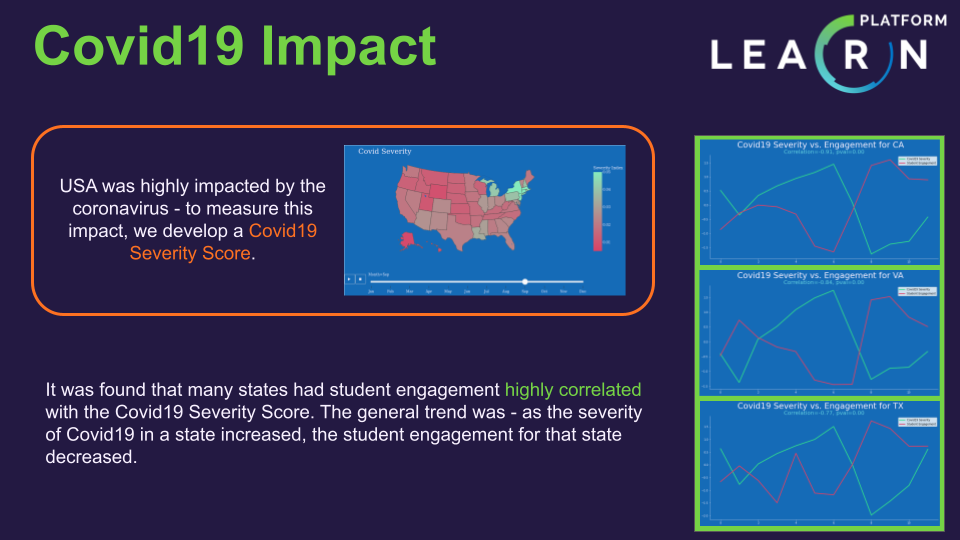

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    Firstly, let us look at the impact of Covid19 on the USA. One way to represent this impact is what I call <b>Covid19 Severity Index</b> which tries to measure the severity of Covid19 in a state.
    <br><br>
    It is given by the formula -
    <br>
    <b>Covid19 Severity Index = ((2 x #Deaths / #Cases) + (1 x #Cases / Population)) / 3</b>
    <br>
    Basically a weighted sum of Death-to-cases ratio & Cases-to-Population ratio. Here the first term is being weighed twice as much as the second term, since cases converting into deaths is much more severe than population converting into cases.
    <br><br>
    Using this newly generated metric, let us analyze how sever Covid has been among different states with time -
</font>
</div>

In [2]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

from scipy.stats import pearsonr

import geopandas as gpd
import libpysal as lps
import esda
from esda.moran import Moran_Local
from esda.moran import Moran
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster
import seaborn as sns
import folium

def load_covid19_severity_data():
    df = pd.read_csv('/kaggle/input/learnplatform-analysis-data/OxCGRT_latest.csv', usecols = ['CountryName', 'RegionName', 'Date', 'Jurisdiction', 'ConfirmedCases', 'ConfirmedDeaths'], parse_dates = ['Date'])
    df = df[(df['CountryName'] == 'United States') & (df['Jurisdiction'] == 'STATE_TOTAL')]
    df = df.drop(['CountryName', 'Jurisdiction'], axis = 1)
    df = df[df['RegionName'] != 'Washington DC'].reset_index(drop = True)
    df['Month'] = df['Date'].apply(lambda x: x.month)

    us_state_pop_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/nst-est2020.csv', usecols = ['NAME', 'POPESTIMATE042020', 'POPESTIMATE2020'])
    us_state_pop_data.columns = ['RegionName', 'Population_April1_2020', 'Population_July1_2020']
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days_in_months = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    middays = [31 // 2]
    for month_idx in range(1, 12):
        middays.append(np.sum(days_in_months[: month_idx - 1]) + days_in_months[month_idx] // 2)
    for month_idx in range(12):
        us_state_pop_data[month_idx + 1] = us_state_pop_data['Population_July1_2020'] + (us_state_pop_data['Population_July1_2020'] - us_state_pop_data['Population_April1_2020']) / (183 - 92) * (middays[month_idx] - 183)
    us_state_pop_data = us_state_pop_data.drop(['Population_April1_2020', 'Population_July1_2020'], axis = 1)
    us_state_pop_data = pd.melt(us_state_pop_data, id_vars = 'RegionName', var_name = 'Month', value_name = 'Population')

    df = pd.merge(df, us_state_pop_data, how = 'left', on = ['RegionName', 'Month'])
    df = df.groupby(['RegionName', 'Month'])[['ConfirmedCases', 'ConfirmedDeaths', 'Population']].aggregate(np.nanmean).reset_index()
    df['death_to_cases_ratio'] = (df['ConfirmedDeaths'] / (df['ConfirmedCases'] + 0.0000000000001))
    df['cases_to_pop_ratio'] = (df['ConfirmedCases'] / (df['Population'] + 0.0000000000001))
    df['covid19_severity_index'] = (2 * df['death_to_cases_ratio'] + df['cases_to_pop_ratio']) / 3.0
    
    #df = df.drop(['ConfirmedCases', 'ConfirmedDeaths', 'Population', 'death_to_cases_ratio', 'cases_to_pop_ratio'], axis = 1)
    return df

covid19_severity_data = load_covid19_severity_data()
covid19_severity_data['RegionName'] = covid19_severity_data['RegionName'].replace(STATE_ABBR)

engagement_data = DATA.groupby(['state', 'month'])[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)

state_vals_df = covid19_severity_data.copy()
title = "Covid Severity - Statewise Timeline"
val_col = "covid19_severity_index"
val_label = "Severity Index"
range_min_val = 0.005
range_max_val = 0.05
theme = 'DARK'

# state_vals_df = covid19_severity_data
# title = "Covid Severity"
# val_col = "ConfirmedCases"
# val_label = "Confirmed Cases"
# range_min_val = 1500
# range_max_val = 2500000
# theme = 'DARK'

state_vals_df['Month'] = state_vals_df['Month'].apply(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][x - 1])

theme = select_theme(theme)

layout = dict(
    font_family = 'Source Sans Pro',
    font_color = theme['text'],
    title_text = title,
    # To change
    title_font = dict(
        family = "Source Sans Pro",
        size = 25,
        color = theme['axis']
    ),
    geo_scope = 'usa',
    paper_bgcolor = theme['bg'],
    geo_bgcolor = theme['bg'],
    geo = dict(
        landcolor = theme['inv'],
        subunitcolor = theme['gray'],
        lakecolor = theme['bg'],
    ),
)

fig = px.choropleth(
    state_vals_df,
    locations = 'RegionName',
    color = val_col,
    color_continuous_scale = [theme['color-1'], theme['color+1_higher']],
    range_color = (range_min_val, range_max_val),
    locationmode = "USA-states",
    labels = {val_col : val_label, 'RegionName': 'State'},
    animation_frame = 'Month'
)

fig.update_layout(layout)
fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
fig.show()

<div>
<font size='+1'>
    Looking at the timeline, there are certain patterns that can be seen. To discover these patterns, <font color='#FD7121'>Spatial Autocorrelation</font> can be used. By comparing a state's value with its neighbouring state's values, the following Moran's Scatterplot can be found -
</font>
</div>

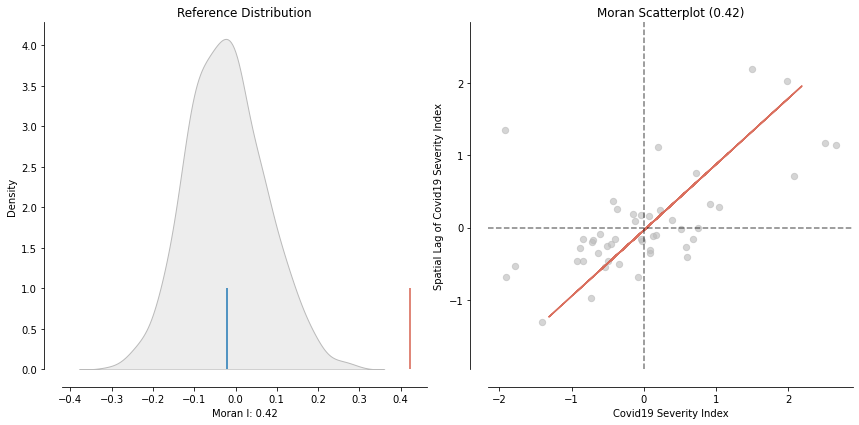

In [3]:
temp_data = covid19_severity_data.groupby('RegionName')['covid19_severity_index'].aggregate(np.nanmean).reset_index(drop = False)

nbr_gdf = gpd.read_file('/kaggle/input/learnplatform-analysis-data/tl_2020_us_state.shp')[['NAME', 'geometry']]
exclude_cols = ['Hawaii', 'United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands', 'Guam', 'American Samoa', 'Puerto Rico', 'Alaska']
nbr_gdf = nbr_gdf[~nbr_gdf['NAME'].isin(exclude_cols)]
nbr_gdf['NAME'] = nbr_gdf['NAME'].replace(STATE_ABBR)
nbr_final = nbr_gdf.merge(temp_data, how = 'inner', right_on = 'RegionName', left_on = 'NAME')

w =  lps.weights.Queen.from_dataframe(nbr_final)
w.transform = 'r'
nbr_final['weighted_covid19_severity_index'] = lps.weights.lag_spatial(w, nbr_final['covid19_severity_index'])
y = nbr_final.covid19_severity_index
moran = esda.Moran(y, w)
plot_moran(moran, zstandard=True, figsize=(12,6))
plt.ylabel('Spatial Lag of Covid19 Severity Index')
plt.xlabel('Covid19 Severity Index')
plt.tight_layout()
plt.show()

<div>
<font size='+1'>
    From this, we understand that there is some correlation of the state's values with its neightbouring states' values. To further analyze, we can identify four kind of states -
    <ol>
        <li><b>HH</b> - State has high severity index & also neighbouring states have high severity index</li>
        <li><b>HL</b> - State has high severity index but neighbouring states have low severity index</li>
        <li><b>LH</b> - State has low severity index but neighbouring states have high severity index</li>
        <li><b>LL</b> - State has low severity index & also neighbouring states have low severity index</li>
    </ol>
</font>
</div>

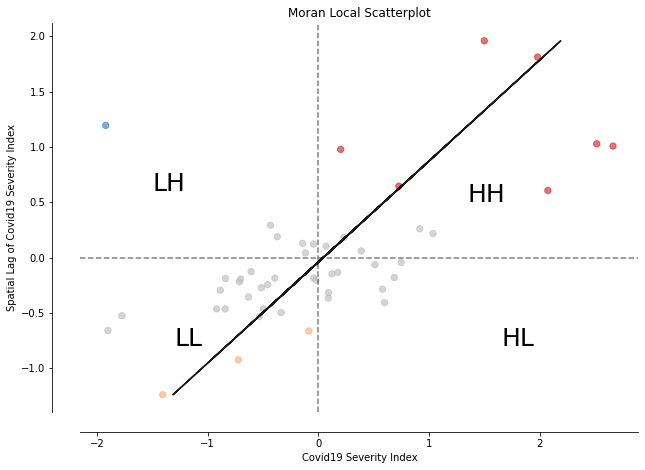

In [4]:
m_local = Moran_Local(y, w)
P_VALUE = 0.05
fig, ax = plt.subplots(figsize=(10,10))
moran_scatterplot(m_local, p=P_VALUE, ax=ax)
ax.set_xlabel('Covid19 Severity Index', fontsize = 10)
ax.set_ylabel('Spatial Lag of Covid19 Severity Index', fontsize = 10)
plt.text(1.35, 0.5, 'HH', fontsize=25)
plt.text(1.65, -0.8, 'HL', fontsize=25)
plt.text(-1.5, 0.6, 'LH', fontsize=25)
plt.text(-1.3, -0.8, 'LL', fontsize=25)
plt.show()

<div>
<font size='+1'>
    Finally, we can identify these states on a map -
</font>
</div>

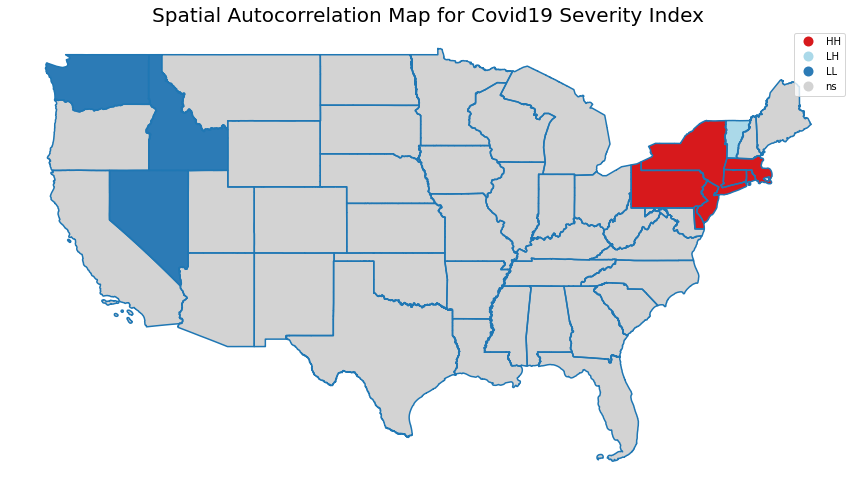

In [5]:
fig, ax = plt.subplots(figsize=(12,10))
lisa_cluster(m_local, nbr_final, p=P_VALUE, ax=ax)
nbr_final.boundary.plot(ax=ax)
plt.title('Spatial Autocorrelation Map for Covid19 Severity Index', fontsize = 20)
plt.tight_layout()
plt.show()

<div>
<font size='+1'>
    As can be seen, regions around New York have high severity while regions around Washington have lower severity. Vermont, despite being in a hotspot, still has managed to keep its severity index low.
</font>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>2 PM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    The twin effect of having lunch and doing relaxing meditation and exercises now had Grace as sleepy as a hibernating bear. Every once a while, I made sure to tap the pen loudly on my table - her sleeping head would suddenly jerk, her eyes would open and the sad reality in front of her laptop screen would chase away her dreams.
    <br><br>
    "Which class is going on?" I asked, just to make her move some part of her face. "<b>Social Studies</b>," came a grim low-tone reply. "What are they teaching right now?" I asked, just to make her look at the screen once.
    <br><br>
    "I think history, yeah maybe history," she said, trying to let some of her screen's light into her eye. I nodded and turned around to continue my work. "So can anyone tell me where on this map is Nevada?" came a sound from Grace's laptop. I smiled.
</font>
</span>
</div>

<div>
<font size='+1'>
    How sleepy do you have to be to confuse geography to history? They are completely different subjects!
    <br><br>
    Geography mostly deals with spatial analysis while history deals with temporal analysis. There is no way you should confuse that - it's like confusing between time and area! They are separate quantities and have separate units of measurement. You don't involve space when talking about time and don't involve time when talking about space...
    <br><br>
    Unless you perform what is called a <b>spatio-temporal analysis</b>. Here is what I found out -
</font>
</div>

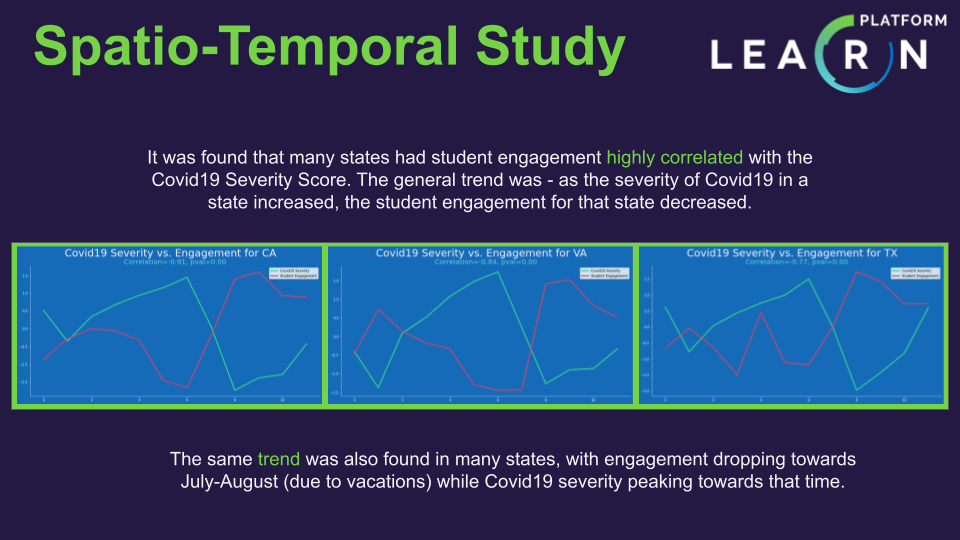

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    Let us now deal with states & time together. The following is an animation showing how covid19 severity changed with time for the 3 most and least affected states.
</font>
</div>

In [6]:
covid_engagement_data = pd.merge(engagement_data, covid19_severity_data, how = 'inner', left_on = ['state', 'month'], right_on = ['RegionName', 'Month'])
statewise_covid_index = covid_engagement_data.groupby('state')['covid19_severity_index'].aggregate(np.nanmean).reset_index(drop = False)

sel_states = ['WA', 'UT', 'VA', 'NJ', 'NY', 'MA']
# sel_states = covid_engagement_data['state'].unique()

datas = {}
for state in sel_states:
    datas[state] = covid_engagement_data[covid_engagement_data['state'] == state]

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1, 1, figsize = (12, 5))

ax.set_xlim(( 0, 12))
ax.set_ylim((0, 0.07))
ax.set_xticks(np.arange(0, 12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title("Covid19 Severity Index Timeline (for certain states)")
ax.set_ylabel("Covid19 Severity Index")
ax.set_xlabel("2020")

lines = {}
for state in sel_states:
    lines[state] = ax.plot([], [], lw=2, label = state)[0]

ax.legend(loc = 'upper right')

# initialization function: plot the background of each frame
def init():
    for state in sel_states:
        lines[state].set_data([], [])
    return set(lines.values())

# animation function. This is called sequentially
def animate(i):
    for state in sel_states:
        y = datas[state][datas[state]['month'] <= i + 1]['covid19_severity_index'].values
        x = np.arange(0, y.shape[0])
        lines[state].set_data(x, y)
    return set(lines.values())

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func = init,
                               frames = 12, interval = 500, blit=True)

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

plt.close()

anim

<div>
<font size='+1'>
    It is interesting to see an upward spike for severaly affected states near September while a downward spike for least affected states around the same time. In fact, only 3 other states showed this upward spike and almost all of them had high Covid19 Severity Index values before September itself. Maybe the severely-hit states were not able to control the cases and the situation got out of hand, while most other states were able to keep their cases under control.
</font>
</div>

<div>
<font size='+1'>
    Now, let us check for any relationship between the Covid19 Severity Index & Student Engagement. The timeline of Covid19 Severity Index was compared with the timeline of Student Engagement for all states. The below states are ones where the correlation was extremely high -
</font>
</div>

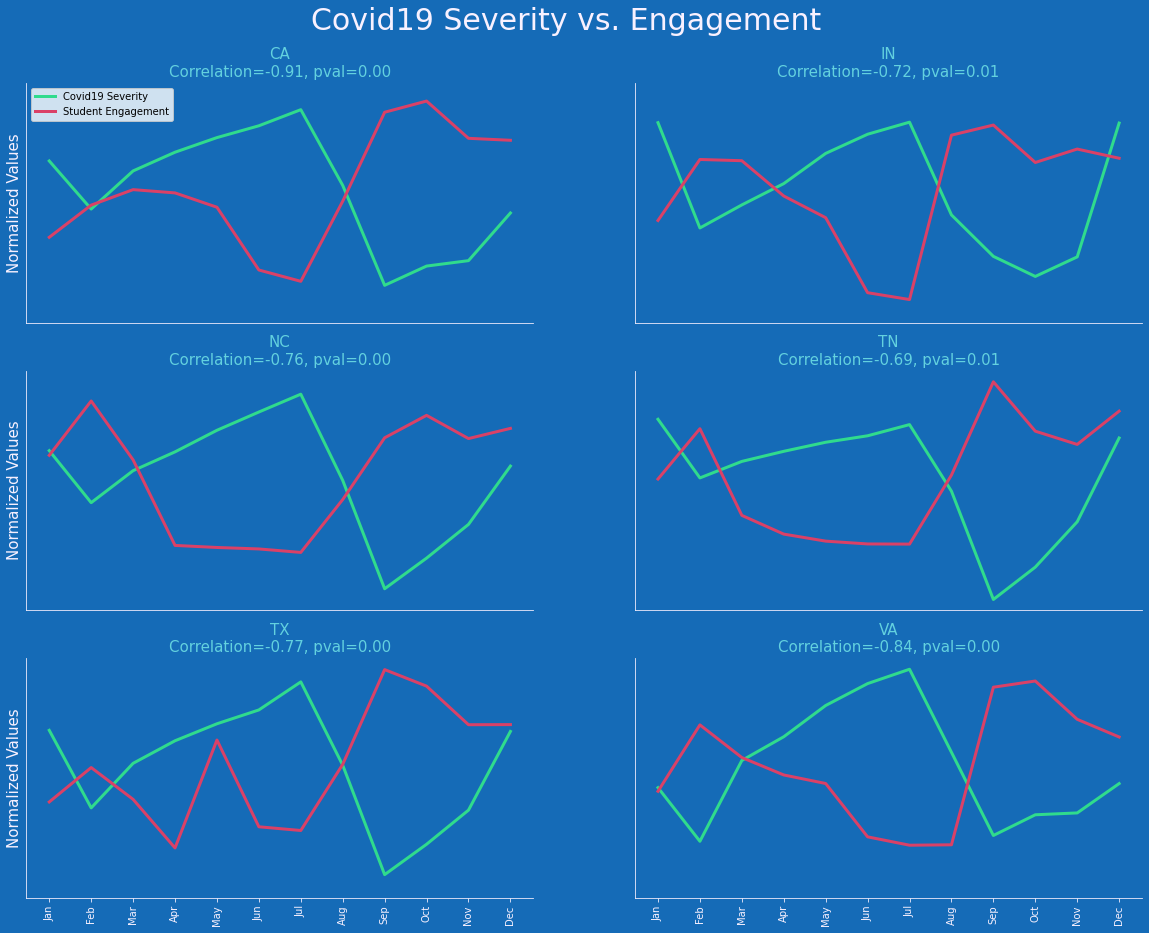

In [7]:
def plot_lines(state, corr, pval, ax, ax_idx = 0):
    x = covid_engagement_data[covid_engagement_data['state'] == state]['covid19_severity_index']
    x = (x - np.mean(x)) / np.std(x)
    y = covid_engagement_data[covid_engagement_data['state'] == state]['engagement_index']
    y = (y - np.mean(y)) / np.std(y)
    
    x_vals = np.arange(12)
    y_vals = [x, y]
    labels = ['Covid19 Severity', 'Student Engagement']
    title = f"{state}\nCorrelation={corr:.2f}, pval={pval:.2f}"
    xlabel = ""
    ylabel = "Normalized Values"
    theme = 'DARK'
    x_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    rotate_x = 90

    theme = select_theme(theme)
    if(len(y_vals) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
    else:
        group_colors = theme['groups'][:len(y_vals)]
    for y_val_idx, y_val in enumerate(y_vals):
        if(len(labels) == 0):
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = f'line #{y_val_idx + 1}')
        else:
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = labels[y_val_idx])
#     ax = set_legend(ax, theme)
    if(ax_idx == 0):
        ax.legend(loc = 'upper left')
    if(ax_idx in [4, 5]):
        ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    else:
        ax.set_xticks([])
    if(ax_idx in [0, 2, 4]):
        ax.set_ylabel(ylabel, fontsize = 15, color = theme['text'])
    if(ax_idx in [1, 3, 5]):
        ax.set_yticks([])
    ax.set_title(title, fontsize = 15, color = theme['subtitle'])
    ax = remove_spines(ax, theme)
    ax = set_ticks(ax, theme)
    ax.set_facecolor(theme['bg'])
    return ax
#     plot_lineplot(np.arange(12), [x, y], suptitle = f"Covid19 Severity vs. Engagement for {state}", title = f"Correlation={corr:.2f}, pval={pval:.2f}", height = 7, width = 15, labels = ['Covid19 Severity', 'Student Engagement'], x_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig, ax = plt.subplots(3, 2, figsize = (20, 15), sharey = True)
    
corrs = {}
corrs_pval = {}
plot_cnt = 0
for state in covid_engagement_data['state'].unique():
    state_data = covid_engagement_data[covid_engagement_data['state'] == state][['covid19_severity_index', 'engagement_index']].dropna()
    if(state_data.shape[0] >= 6):
        corrs[state], corrs_pval[state] = pearsonr(state_data['covid19_severity_index'], state_data['engagement_index'])
        if(corrs_pval[state] < 0.05):
            if(state not in ['CA', 'IN', 'NC', 'TN', 'TX', 'VA']):
                continue
            ax[int(plot_cnt // 2)][int(plot_cnt % 2)] = plot_lines(state, corrs[state], corrs_pval[state], ax[int(plot_cnt // 2)][int(plot_cnt % 2)], ax_idx = plot_cnt)
            plot_cnt += 1
            if(plot_cnt == 6):
                break
fig.set_facecolor(theme['bg'])
fig.suptitle(f"Covid19 Severity vs. Engagement", fontsize = 30, color = theme['text'], y = 0.95)
plt.show()

<div>
<font size='+1'>
    Interestingly, a very high negative correlation was observed (implying engagement increased as covid19 severity decreased). Also a very clear trend can be seen above - as earlier noticed, student engagement took a drop around July due to vacations and later increased in September, while Covid19 Severity increased around June and like most other states (as shown in the previous graph) took a drop near September. This unique trend might be causing extremely high correlations for these states.
</font>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>3 PM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    It had finally come - the last hour of online classes! The last hour was generally reserved for two optional subjects which the students could choose for half an hour each. Grace had firstly opted for <b>Arts</b>.
    <br><br>
    She absolutely loves it and why shouldn't she? She gets to learn skills like acting & photography (which is where her future ambitions have stemmed from) along with other exciting hobbies like music, dance and ceramic.
    <br><br>
    But obviously, all of this becomes fun when you actually do it along with your friends. Not when you watch someone else do it through a laptop screen. The online Arts class was incredibly underwhelming for Grace. "Oh, how I miss the Arts classes back in school!" she would cry. "I don't want to paint or act all alone, I want my friends here. Oh, when will we be able to go back to school?"
</font>
</span>
</div>

<div>
<font size='+1'>
    That is a question which millions of people debate over. That is a question that the government has to face a lot of heat for. That is a question on the lips of every student, teacher & parent.
    <br><br>
    The pandemic has complicated the entire situation and it seems the answer to the above question is not as straightforward as one would expect. Government policies need to consider several factors relating health, finance & administration before taking a decision on reopening schools.
    <br><br>
    This made me wonder whether government policies would have any impact on student engagement? Whether the government's past measures and future plans have any effect on the present student engagement? I decided to check this out and here is what I found -
</font>
</div>

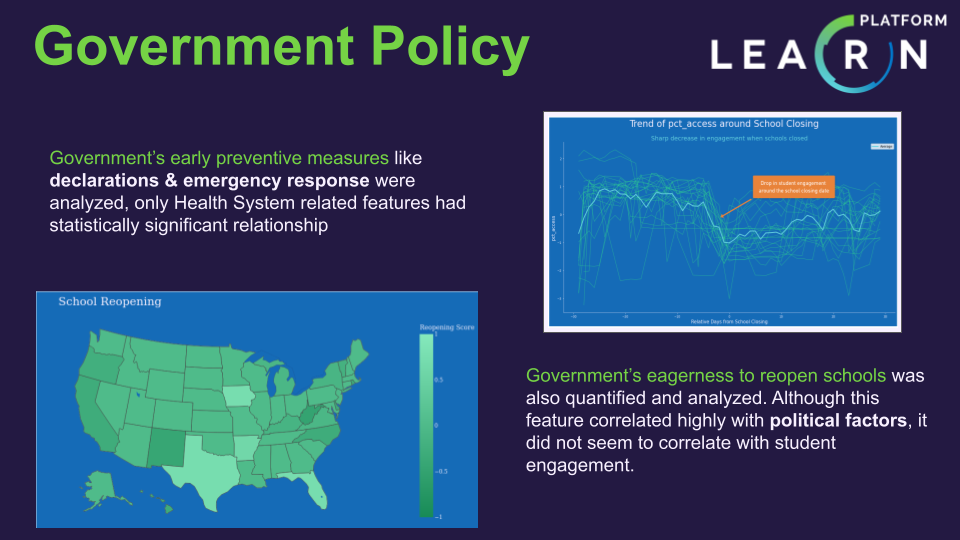

<div>
    <font size='+2' color='#0DAB6C'>
        <b>Detailed Analysis</b>
    </font>
</div>

<div>
<font size='+1'>
    Firstly, let us try and quantify how the government had responded to the emergency. For this, we would be using two different kinds of features. Firstly we compare the dates when different declarations were made (like school closing, state emergency) with March 11, 2020 as the reference date (when WHO declared the pandemic). States which made these important declarations early would be scored high.
    <br><br>
    Secondly, we use OxCGRT indicators. Since there are many indicators, we can repeat the process of using the first PCA component to simplify our analysis. Based on the components, we can get an idea about what each PCA component actually represents -
    <ul>
        <li><b>Containment & Closure</b> - High value indicates good government response with regards to social distancing</li>
        <li><b>Economic Response</b> - High value indicates more income support & debt relief</li>
        <li><b>Health Systems</b> - High value indicates good public campaigning</li>
    </ul>
</font>
</div>

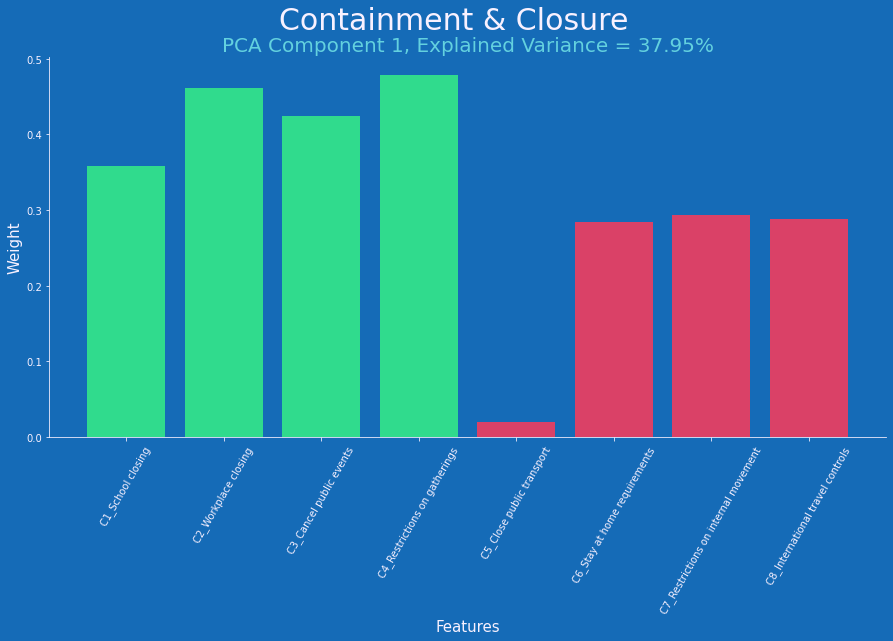

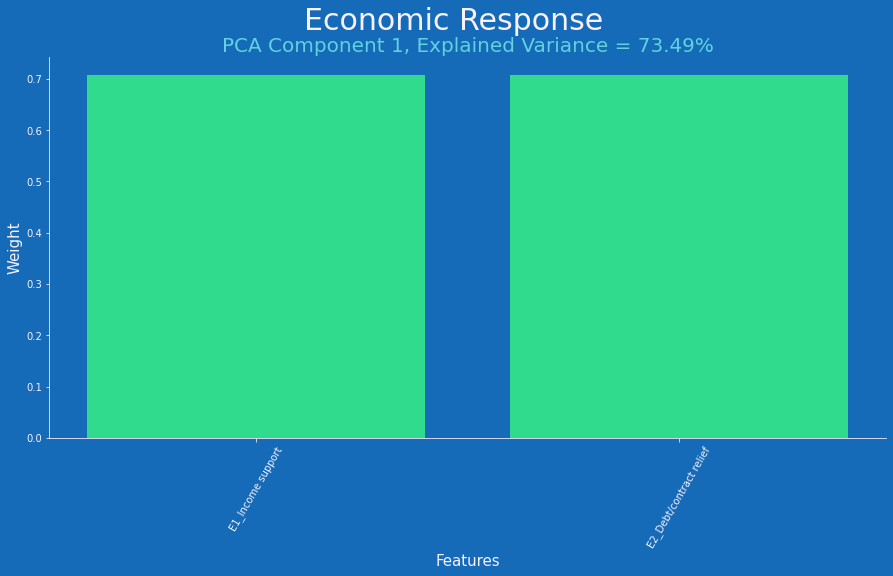

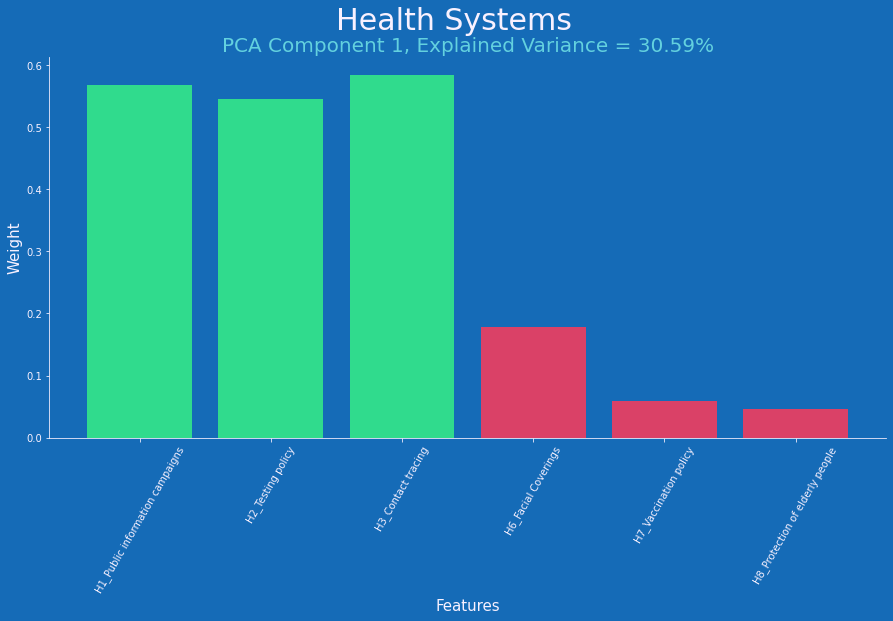

In [8]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

WHO_PANDEMIC_ANNOUNCEMENT_DATE = datetime(2020, 3, 11)

relevant_cols = [
    'STATE',
    'POSTCODE',
    'STEMERG',
    'CLSCHOOL',
    'STAYHOME',
    'STAYHOMENOGP',
    'FM_ALL',
    'FM_EMP',
]

data = pd.read_excel('/kaggle/input/learnplatform-analysis-data/COVID-19 US state policy database 3_29_2021.xlsx', usecols = relevant_cols)
data = data.drop([0, 1, 2, 3], axis = 0)
data = data[pd.isnull(data['STATE']) == False]
data = data.replace({0: np.nan})
for col in data.columns[2:]:
    data[col] = data[col].astype(np.datetime64)

def find_earliest_date(row, cols_to_compare = []):
    return min(*[row[x] for x in cols_to_compare])
data['STAYHOME'] = data.apply(find_earliest_date, axis = 1, cols_to_compare = ['STAYHOME', 'STAYHOMENOGP'])
data = data.drop('STAYHOMENOGP', axis = 1)
data['FM_ALL'] = data.apply(find_earliest_date, axis = 1, cols_to_compare = ['FM_ALL', 'FM_EMP'])
data = data.drop('FM_EMP', axis = 1)

dates_data = data.copy()

for col in data.columns[2:]:
    data[col] = data[col].apply(lambda x: ((x - WHO_PANDEMIC_ANNOUNCEMENT_DATE).days) / 7)

usecols = [
    'CountryName',
    'RegionName',
    'Jurisdiction',
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'E1_Income support',
    'E2_Debt/contract relief',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'H6_Facial Coverings',
    'H7_Vaccination policy',
    'H8_Protection of elderly people',
]
df = pd.read_csv('/kaggle/input/learnplatform-analysis-data/OxCGRT_latest.csv', usecols = usecols)
df = df[(df['CountryName'] == 'United States') & (df['Jurisdiction'] == 'STATE_TOTAL')]
df = df.drop(['CountryName', 'Jurisdiction'], axis = 1)
df = df[df['RegionName'] != 'Washington DC'].reset_index(drop = True)
df = df.groupby('RegionName')[[x for x in df.columns if x != 'RegionName']].aggregate(np.nanmean).reset_index(drop = False)

df['RegionName'] = df['RegionName'].replace(STATE_ABBR)

from sklearn.decomposition import PCA

policy_metrics_names = []
policy_metrics = []

C_cols = [x for x in df.columns if x.startswith('C')]
E_cols = [x for x in df.columns if x.startswith('E')]
H_cols = [x for x in df.columns if x.startswith('H')]

for feat_idx, feats in enumerate([C_cols, E_cols, H_cols]):

    data_for_pca = df[feats]
    for col in data_for_pca.columns:
        data_for_pca[col] = (data_for_pca[col] - data_for_pca[col].mean()) / (data_for_pca[col].std() + 0.0000000000001)

    pca = PCA(n_components = 1)
    pca_orig_data = pca.fit_transform(data_for_pca)
    for pca_idx in range(1):
        pca_data = pca.components_[pca_idx]
        expl_var = np.sum(pca.explained_variance_ratio_[:pca_idx + 1]) * 100
        if(pca_data.sum() < 0):
            pca_data = -pca_data
        
        policy_metrics.append(pca_orig_data[:, pca_idx])
        if(feat_idx == 0):
            policy_metrics_names.append(f'C_{pca_idx+1}')
        elif(feat_idx == 1):
            policy_metrics_names.append(f'E_{pca_idx+1}')
        elif(feat_idx == 2):
            policy_metrics_names.append(f'H_{pca_idx+1}')

        if(pca_idx == 0):
            if(feat_idx == 0):
                cats = [0, 0, 0, 0, 1, 1, 1, 1]
                col_name = 'Containment & Closure'
            elif(feat_idx == 1):
                cats = [0, 0]
                col_name = "Economic Response"
            elif(feat_idx == 2):
                cats = [0, 0, 0, 1, 1, 1]
                col_name = "Health Systems"
            
            plot_barplot(
                [x for x in feats], pca_data,
                width = 15, height = 7,
                suptitle = f"{col_name}", title = f"PCA Component {pca_idx + 1}, Explained Variance = {expl_var:.2f}%",
                xlabel = "Features", ylabel = "Weight",
                rotate_x = 60,
                theme = 'DARK',
                cats = cats
            )
        
        if(expl_var >= 70):
            break

<div>
<font size='+1'>
    When comparing the correlations of these government policy features with student engagement, it was found that only Health Systems seemed to have a statistically significant correlation of around 0.5. Other government responses seemed to  not have much effect.
</font>
</div>

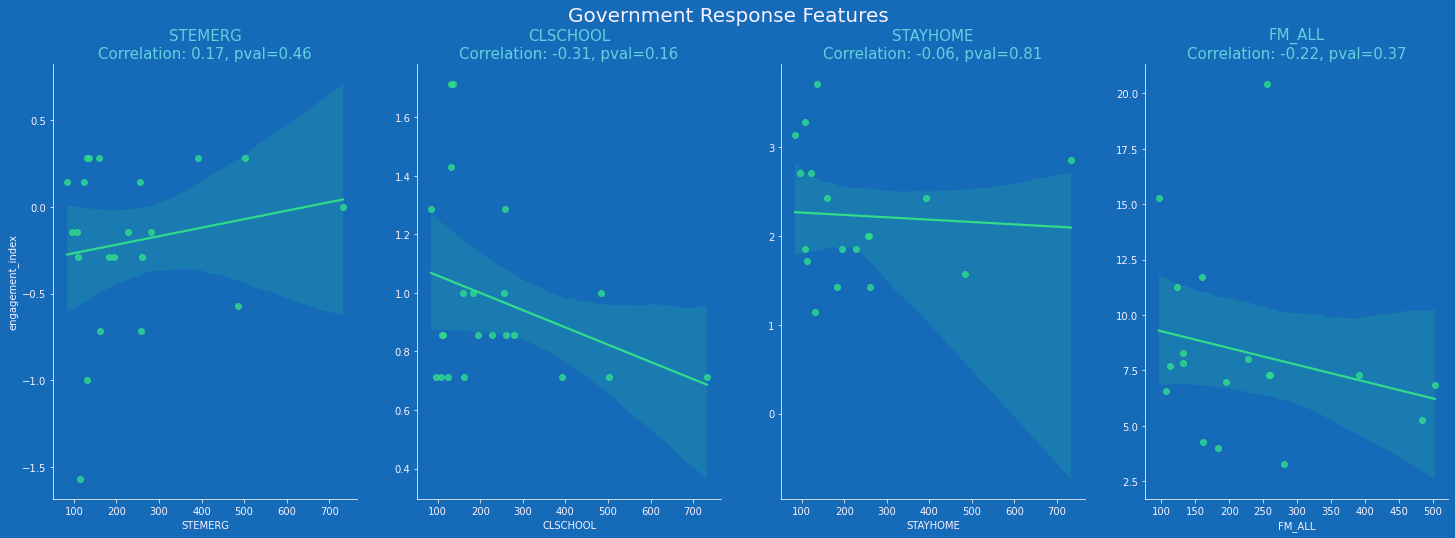

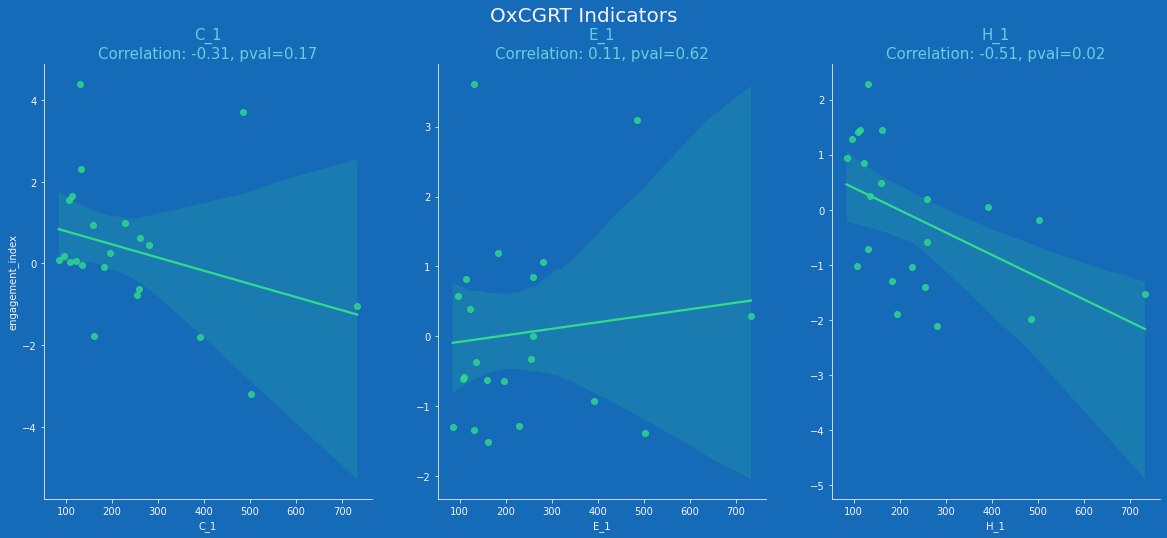

In [9]:
policy_data_metrics = pd.DataFrame(np.asarray(policy_metrics).transpose(), columns = policy_metrics_names)
#print(data.shape, social_vulnerability_metrics.shape)
policy_data = pd.concat([df[['RegionName']], policy_data_metrics], axis = 1)
policy_data = policy_data.groupby('RegionName')[policy_metrics_names].aggregate(np.nanmean).reset_index(drop = False)
data = pd.merge(data, policy_data, how = 'inner', left_on = 'POSTCODE', right_on = 'RegionName')

engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)
policy_engagement_data = pd.merge(engagement_data, data, how = 'inner', left_on = 'state', right_on = 'POSTCODE')

fig, ax = plt.subplots(1, 4, figsize = (25, 8))
#for col in ['STEMERG', 'CLSCHOOL', 'STAYHOME', 'FM_ALL', 'C_1', 'E_1', 'H_1']:
for col_idx, col in enumerate(['STEMERG', 'CLSCHOOL', 'STAYHOME', 'FM_ALL']):
    col_data = policy_engagement_data[['engagement_index', col]].dropna()
    
    sns.regplot(
        x = col_data['engagement_index'],
        y = col_data[col],
        ax = ax[col_idx],
        color = COLOR_GREEN,
    )

    theme = select_theme('DARK')
    for a in ax:
        fig, a = set_bg(fig, a, theme)
        a = set_ticks(a, theme)
        a = remove_spines(a, theme)
    corr, corr_pval = pearsonr(col_data['engagement_index'], col_data[col])
    ax[col_idx].set_title(f"{col}\nCorrelation: {corr:.2f}, pval={corr_pval:.2f}", fontsize = 15, color = theme['subtitle'])
    ax[col_idx].set_xlabel(col, fontsize = 10, color = theme['text'])
    if(col_idx == 0):
        ax[col_idx].set_ylabel("engagement_index", fontsize = 10, color = theme['text'])
    else:
        ax[col_idx].set_ylabel("")
fig.suptitle("Government Response Features", fontsize = 20, color = theme['text'])
plt.show()

fig, ax = plt.subplots(1, 3, figsize = (20, 8))
for col_idx, col in enumerate(['C_1', 'E_1', 'H_1']):
    col_data = policy_engagement_data[['engagement_index', col]].dropna()
    
    sns.regplot(
        x = col_data['engagement_index'],
        y = col_data[col],
        ax = ax[col_idx],
        color = COLOR_GREEN,
    )

    theme = select_theme('DARK')
    for a in ax:
        fig, a = set_bg(fig, a, theme)
        a = set_ticks(a, theme)
        a = remove_spines(a, theme)
    corr, corr_pval = pearsonr(col_data['engagement_index'], col_data[col])
    ax[col_idx].set_title(f"{col}\nCorrelation: {corr:.2f}, pval={corr_pval:.2f}", fontsize = 15, color = theme['subtitle'])
    ax[col_idx].set_xlabel(col, fontsize = 10, color = theme['text'])
    if(col_idx == 0):
        ax[col_idx].set_ylabel("engagement_index", fontsize = 10, color = theme['text'])
    else:
        ax[col_idx].set_ylabel("")
fig.suptitle("OxCGRT Indicators", fontsize = 20, color = theme['text'])
plt.show()

<div>
<font size='+1'>
    Another idea that I worked on was the impact of closing schools on student engagement. To do this, I checked the engagement levels for each states 1 month before and after schools were closed in that state. The results showed that contrary to my intuition, a sharp decrease was observed in pct_access around the time schools were closed. For engagement_index, the decrease is not obvious.
</font>
</div>

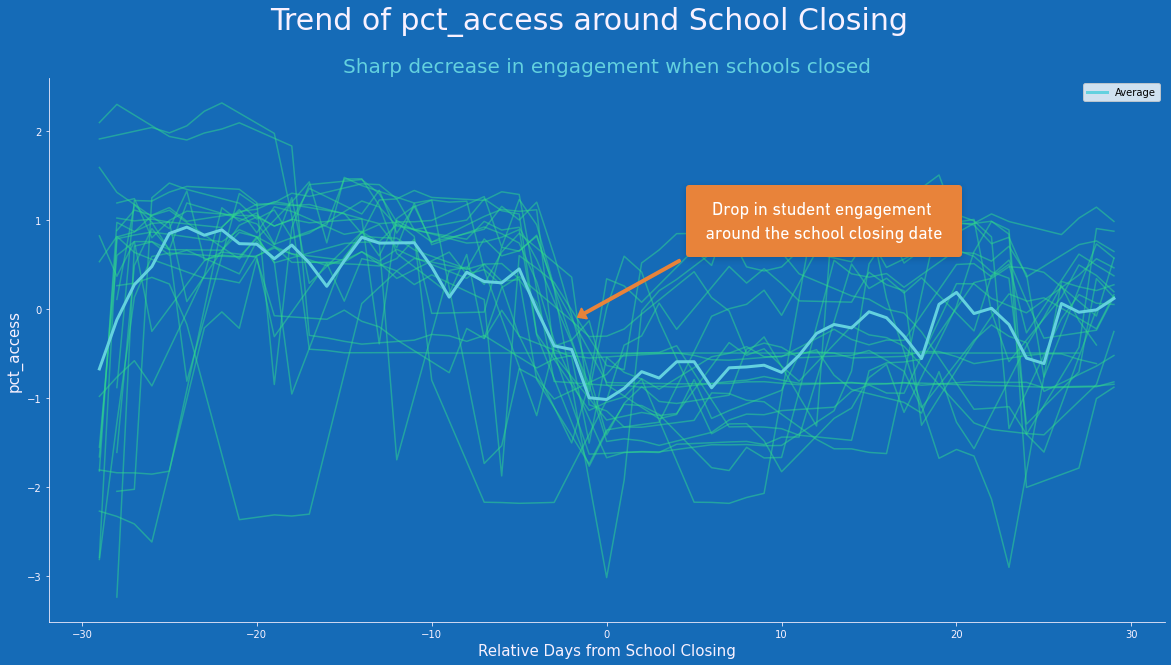

In [10]:
from datetime import datetime, timedelta
before_after_reopening_pct_access = []
before_after_reopening_engagement_index = []
before_after_reopening_rel_dates = []
for state in dates_data['POSTCODE'].unique():
    school_closing_date = dates_data[dates_data['POSTCODE'] == state].iloc[0]['CLSCHOOL']
    min_date = school_closing_date - timedelta(30)
    max_date = school_closing_date + timedelta(30)
    state_data = DATA[(DATA['time'] < max_date) & (DATA['time'] > min_date)]
    state_data = state_data[state_data['is_weekend'] == 0]
    if(state_data.shape[0] == 0):
        continue
    state_data = state_data[state_data['state'].replace(STATE_ABBR) == state]
    state_data = state_data.groupby(['state', 'time'])[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
    state_data['relative_time'] = state_data['time'].apply(lambda x: (x - school_closing_date).days)
    if(state_data.shape[0] == 0):
        continue
    def normalize(x):
        return (x - x.mean()) / (x.std() + 0.00000000000000000000001)
    before_after_reopening_pct_access.append(normalize(state_data['pct_access']))
    before_after_reopening_engagement_index.append(normalize(state_data['engagement_index']))
    before_after_reopening_rel_dates.append(state_data['relative_time'])

tot_days = np.median([len(x) for x in before_after_reopening_pct_access])
half_days = tot_days // 2

avg = []
for rel_date_idx in range(-29, 30):
    val_sum = 0
    val_cnt = 0
    for idx in range(len(before_after_reopening_pct_access)):
        for date_idx in range(len(before_after_reopening_rel_dates[idx])):
            if(before_after_reopening_rel_dates[idx][date_idx] == rel_date_idx):
                val_sum += before_after_reopening_pct_access[idx][date_idx]
                val_cnt += 1
    if(val_cnt == 0):
        print("ERROR!")
    else:
        avg.append(val_sum / val_cnt)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
for idx in range(len(before_after_reopening_pct_access)):
    sns.lineplot(x = before_after_reopening_rel_dates[idx], y = before_after_reopening_pct_access[idx].values, ax = ax, color = COLOR_GREEN, alpha = 0.5)
sns.lineplot(x = np.arange(-29, 30), y = avg, ax = ax, color = COLOR_LIGHT_BLUE, alpha = 1, lw = 3, label = 'Average')

theme = select_theme('DARK')
suptitle = "Trend of pct_access around School Closing"
title = "Sharp decrease in engagement when schools closed"
xlabel = "Relative Days from School Closing"
ylabel = "pct_access"
ax.legend(loc = 'best')
exec(plot_decoration())
from PIL import Image
img = Image.open('/kaggle/input/learnplatform-analysis-data/drop_infographic.png')
# img = img.resize((150, 200))
height = img.size[1]
fig.figimage(img, 550, fig.bbox.ymax - 400)
plt.show()

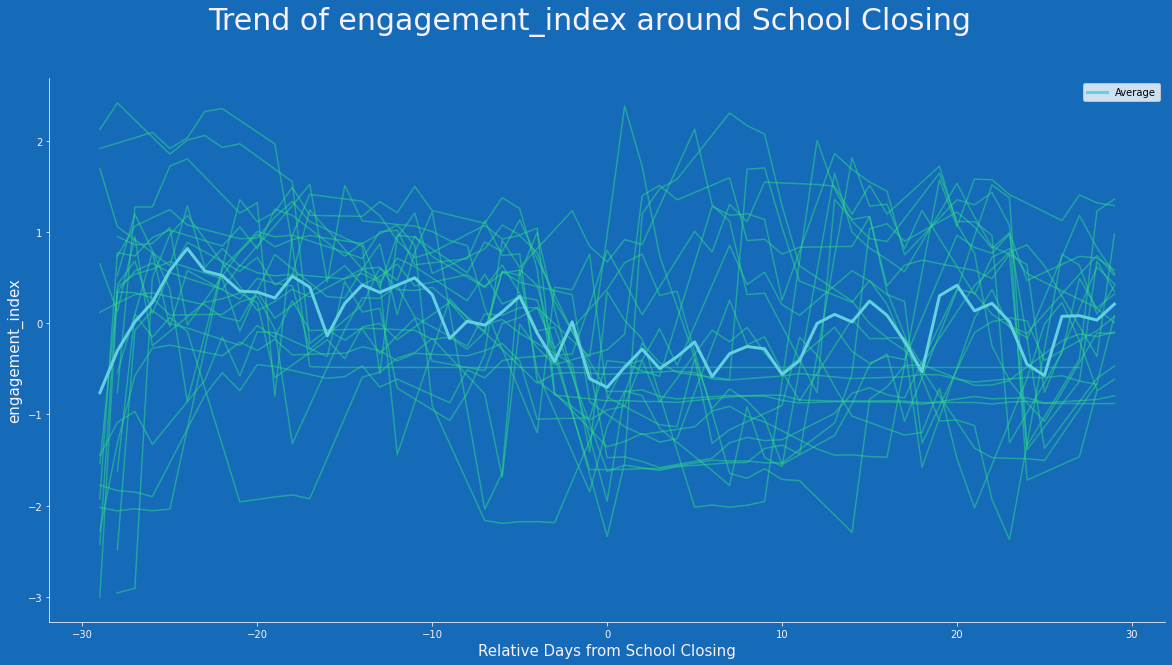

In [11]:
avg = []
for rel_date_idx in range(-29, 30):
    val_sum = 0
    val_cnt = 0
    for idx in range(len(before_after_reopening_engagement_index)):
        for date_idx in range(len(before_after_reopening_rel_dates[idx])):
            if(before_after_reopening_rel_dates[idx][date_idx] == rel_date_idx):
                val_sum += before_after_reopening_engagement_index[idx][date_idx]
                val_cnt += 1
    if(val_cnt == 0):
        print("ERROR!")
    else:
        avg.append(val_sum / val_cnt)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
for idx in range(len(before_after_reopening_engagement_index)):
    sns.lineplot(x = before_after_reopening_rel_dates[idx], y = before_after_reopening_engagement_index[idx].values, ax = ax, color = COLOR_GREEN, alpha = 0.5)
sns.lineplot(x = np.arange(-29, 30), y = avg, ax = ax, color = COLOR_LIGHT_BLUE, alpha = 1, lw = 3, label = 'Average')
    
theme = select_theme('DARK')
suptitle = "Trend of engagement_index around School Closing"
title = ""
xlabel = "Relative Days from School Closing"
ylabel = "engagement_index"
ax.legend(loc = 'best')
exec(plot_decoration())
plt.show()

<div>
<font size='+1'>
    Since we are analysing the impact of school closing on engagement levels, why not try and see whether plans to reopen schools has any impact on student engagement. After receiving permission, I have used a really nice dataset from EdWeek which tracks the school reopening plan for different states.
    <br><br>
    Using this dataset, I came up with a <b>Reopening Score</b> which represents whether states are eager to reopen schools. Higher the Reopening Score, more eager are the states to reopen schools.
    <br><br>
    After plotting the scores on a map and finding its correlation with student engagement, it was however observed that there is no statistically significant correlation between the two.
</font>
</div>

In [12]:
import numpy as np
import pandas as pd
import os
import re
import sys

import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import pearsonr

dates_avail = [
    (8, 19),
    (8, 21),
    (8, 28),
    (9, 3),
    (9, 11),
    (9, 18),
    (9, 25),
    (10, 2),
    (10, 5),
    (10, 9),
    (10, 16),
    (10, 23),
    (10, 30),
    (11, 6),
    (11, 13),
    (11, 20),
    (11, 25),
    (12, 4),
    (12, 11),
    (12, 18),
    (12, 23)
]

all_data = pd.DataFrame()
for date in dates_avail:
    df = pd.read_excel('/kaggle/input/learnplatform-analysis-data/School_Reopening_Plans (copy).xlsx', sheet_name = f'Map Data {date[0]}.{date[1]}.20', usecols = ['State_Abbr', 'Status'])
    df['Date'] = pd.Series([datetime(2020, date[0], date[1])] * df.shape[0], index = df.index)
    all_data = pd.concat([all_data, df], axis = 0).reset_index(drop = True)

all_data['Updated_Status'] = all_data['Status'].replace({
    '  No order': 'No order',
    'No order in effect': 'No order',
    'Partial closure in effect': 'Partial closure',
    'Full closure in effect': 'Full closure',
    'State ordered closure in effect (including states where openings are delayed)': 'Full closure',
    'State-ordered regional closure in effect': 'Partial closure',
    'Only hybrid or remote instruction allowed': 'Partial closure',
    'State-ordered in-person instruction available part-time or full-time*': 'Partial open',
    'Varies by school/district/dependent on local health authorities': 'No order'
})

def define_reopening_score(status):
    if(status == 'No order'):
        return 0
    elif(status == 'Full closure'):
        return -1
    elif(status == 'Partial closure'):
        return -0.3
    elif(status == 'Partial open'):
        return 0.3
    elif(status == 'Ordered open'):
        return 1
    else:
        print("Found unknown value")

all_data['Reopening_Score'] = all_data['Updated_Status'].apply(define_reopening_score)
all_data = all_data.groupby('State_Abbr')['Reopening_Score'].aggregate(np.nanmean).reset_index(drop = False)

redblue_states = pd.read_csv('/kaggle/input/learnplatform-analysis-data/Political_RedBlueState.csv')
reopening_political_data = pd.merge(all_data, redblue_states, how = 'inner', on = 'State_Abbr')

engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)
reopening_engagement_data = pd.merge(engagement_data, all_data, how = 'inner', left_on = 'state', right_on = 'State_Abbr')
corr, corr_pval = pearsonr(reopening_engagement_data['engagement_index'], reopening_engagement_data['Reopening_Score'])

plot_us_map(reopening_political_data, f"School Reopening Scores Map: Correlation={corr:.2f}, pval={corr_pval:.2f}", 'Reopening_Score', 'Score', -1, 1, theme = 'DARK', state_col = 'State_Abbr')

<div>
<font size='+1'>
    Finally, government policy and response is not straightforward. It is fair to say that a lot of dirty politics would have been involved in each decision. This is because the covid19 pandemic was seen by many politicians as a basis to argue and debate and forward their own propoganda. Hence, the effect of the Political Landscape must also be checked. Here the red & blue state status will be used as a political feature.
</font>
</div>

In [13]:
from IPython.display import HTML, display
import tabulate

redblue_states = pd.read_csv('/kaggle/input/learnplatform-analysis-data/Political_RedBlueState.csv')
policy_political_data = pd.merge(policy_engagement_data, redblue_states, how = 'inner', left_on = 'state', right_on = 'State_Abbr')

# plot_us_map(reopening_political_data, "Political Alignment", 'WonByBiden', 'Won By Biden', 0, 1, theme = 'DARK', state_col = 'State_Abbr')

state_vals_df = reopening_political_data
title = "Political Landscape - Red & Blue States"
val_col = 'WonByBiden'
val_label = 'Won By Biden'
range_min_val = 0
range_max_val = 1
theme = 'LIGHT'
state_col = 'State_Abbr'
    
theme = select_theme(theme)

layout = dict(
    font_family = 'Source Sans Pro',
    font_color = theme['text'],
    title_text = title,
    # To change
    title_font = dict(
        family = "Source Sans Pro",
        size = 25,
        color = theme['axis']
    ),
    geo_scope = 'usa',
    paper_bgcolor = theme['bg'],
    geo_bgcolor = theme['bg'],
    geo = dict(
        landcolor = theme['inv'],
        subunitcolor = theme['gray'],
        lakecolor = theme['bg'],
    ),
)

fig = px.choropleth(
    state_vals_df,
    locations = state_col,
    color = val_col,
    color_continuous_scale = ['red', 'blue'],
    range_color = (range_min_val, range_max_val),
    locationmode = "USA-states",
    labels = {val_col : val_label, state_col: 'State'},
)

fig.update_layout(layout)
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
fig.show()

<div>
<font size='+1'>
    When comparing the political factors with different government policies, it was found that the stay-at-home, Economic Response & Health Systems policies of the state government were influenced by whether the state was Red or Blue. Further even the reopening of schools seems to be a politically influenced decision.
    <br><br>
    However, political factors do not seem to be affecting Student Engagement.</font>
</div>

In [14]:
political_corr = [
    ['FEATURE', 'CORRELATION WITH POLITICS', 'CORRELATION P-VALUE']
]
for col in ['STEMERG', 'CLSCHOOL', 'STAYHOME', 'FM_ALL', 'C_1', 'E_1', 'H_1']:
    col_data = policy_political_data[['WonByBiden', col]].dropna()
    row = []
    row.append(f"Government Policy - {col}")
    corr, corr_pval = pearsonr(col_data['WonByBiden'], col_data[col])
    row.append(f"{corr:.2f}")
    row.append(f"{corr_pval:.2f}")
    political_corr.append(row)

political_corr.append(['', '', ''])

engagement_data = DATA.groupby('state')[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)
political_engagement_data = pd.merge(engagement_data, redblue_states, how = 'inner', left_on = 'state', right_on = 'State_Abbr')

row = []
row.append("Reopening Score")
corr, corr_pval = pearsonr(reopening_political_data['Reopening_Score'], reopening_political_data['WonByBiden'])
row.append(f"{corr:.2f}")
row.append(f"{corr_pval:.2f}")
political_corr.append(row)

political_corr.append(['', '', ''])

row = []
row.append("pct_access")
corr, corr_pval = pearsonr(political_engagement_data['pct_access'], political_engagement_data['WonByBiden'])
row.append(f"{corr:.2f}")
row.append(f"{corr_pval:.2f}")
political_corr.append(row)

row = []
row.append("engagement_index")
corr, corr_pval = pearsonr(political_engagement_data['engagement_index'], political_engagement_data['WonByBiden'])
row.append(f"{corr:.2f}")
row.append(f"{corr_pval:.2f}")
political_corr.append(row)

display(HTML(tabulate.tabulate(political_corr, tablefmt='html')))

FEATURE,CORRELATION WITH POLITICS,CORRELATION P-VALUE
Government Policy - STEMERG,-0.13,0.56
Government Policy - CLSCHOOL,-0.23,0.31
Government Policy - STAYHOME,-0.56,0.02
Government Policy - FM_ALL,0.03,0.92
Government Policy - C_1,0.33,0.13
Government Policy - E_1,0.48,0.02
Government Policy - H_1,-0.45,0.03
,,
Reopening Score,-0.37,0.01
,,


<div align='center'>
    <font size='+2' color='#75D345'>
        <a style="background-color:#63D1DF; padding: 15px;" href='https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-4-finally-done' target="_blank">Next: <b>Finally Done!</b></a>
    </font>
</div>